<a href="https://colab.research.google.com/github/Arvinth-s/MIMO/blob/main/mimo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#OM NAMO NARAYANA

In [2]:
from scipy import io
import os

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
target_dir = '/content/drive/MyDrive/Antenna/project/'
os.listdir(target_dir)

['rxSig11-sample.mat',
 'rxSig21-sample.mat',
 'rxSig12-sample.mat',
 'target-sample.mat']

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch

In [4]:
from scipy.stats import unitary_group
import random
import math
import numpy as np
import cmath
from torch.optim import optim

In [5]:
 def NoiseChannel(Nt, Nr):
  U = unitary_group.rvs(Nt)
  V = unitary_group.rvs(Nr)
  random.seed(10)
  diag = []
  for i in range(min(Nt, Nr)):
    phi = random.random()*math.pi*2
    diag.append(cmath.rect(1, phi))
  sigma = np.zeros((Nt, Nr), complex)
  np.fill_diagonal(sigma, diag)
  H = np.matmul(U, sigma)
  H = np.matmul(H, np.conj(V))
  var = 1
  n = np.random.normal(0, var, (Nr, 2)).view(np.complex128)
  return H, n

In [329]:
mt = 100
mr = 200
Nt = 2
Nr = 3

In [330]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.linear1 = nn.Linear(Nt, 500)
        self.linear2 = nn.Linear(500, 2*mt)
        self.tren_layer = nn.Linear(2*mt, 2*mr)
        # Define sigmoid activation and softmax output 
        self.linear3 = nn.Linear(2*mr, 500)
        self.linear4 = nn.Linear(500, Nt)
        self.output = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.ch, self.n = NoiseChannel(mr, mt)
        self.encoder= True
        
        
    def channel(self, x, var = 1):
      ch, n = self.ch, self.n
      n = np.random.normal(0, var, (mr, 2)).view(np.complex128)
      y = np.array(x.detach())
      y = y.reshape(y.shape[0], int(y.shape[1]/2), 2).view(np.complex64)
      y = y[:, :].squeeze()
      y = np.matmul(y, np.transpose(ch))
      n = np.repeat(n, y.shape[0], axis=1)
      y = y + np.transpose(n)
      x = torch.tensor(y, requires_grad=False)
      x = torch.view_as_real(x)
      x = torch.reshape(x, (x.shape[0], x.shape[1]*2))
      x = x.float()
      x.requires_grad=True
      return x

    def train_encoder(self, val = False):
        self.encoder = val
        lt = 2
        ct = 0
        for child in model.children():
          if(ct >= 2):
            break
          ct += 1
          for param in child.parameters():
            param.requires_grad=val

    def forward(self, x):
        # Pass the input tensor through each of our operations
        # y = x
        x = self.linear1(x)
        x = self.linear2(x)
        if (self.encoder == False):
          x = self.channel(x)
        else:
          x = self.tren_layer(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.output(x)
        
        return x

In [331]:
model = Network()
lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.BCELoss()

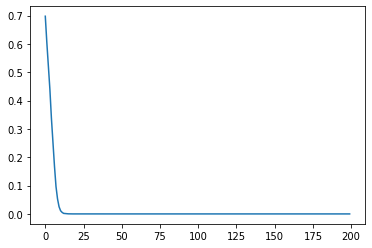

In [332]:
#training encoder
losses = []
epoches = 100
model.train_encoder(True)
for epoch in range(epochs):
  optimizer.zero_grad()
  x = torch.tensor(np.random.randint(0, 2, (100, 2)), dtype = torch.float32)
  pred = model(x)
  loss = criterion(pred, x)
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
plt.plot(np.arange(len(losses)), losses)

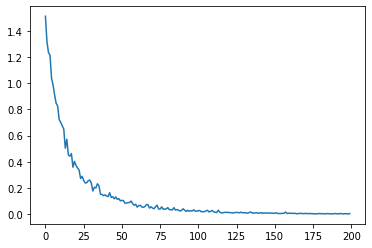

In [333]:
#training decoder with AWGN
lr = 5e-6
epochs = 200
batch_size = 50
model.train_encoder(False)
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.BCELoss()
losses = []
for epoch in range(epochs):
  batch_loss = []
  for batch in range(batch_size):
    optimizer.zero_grad()
    x = torch.tensor(np.random.randint(0, 2, (101, 2)), dtype = torch.float32)
    pred = model(x)
    loss = criterion(pred, x)
    batch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
  losses.append(sum(batch_loss)/len(batch_loss))
plt.plot(np.arange(len(losses)), losses)

In [334]:
target_dir = '/content/drive/MyDrive/Antenna/project/'
# del input
i = input()
torch.save(model, target_dir + 'weights/model/' + i + '.pt')
torch.save(model, target_dir + 'weights/optimizer/' + i + '.pt')

2
